In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#!pip install mne

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import math
import mne
%matplotlib inline

In [4]:
epochs = mne.read_epochs('Data/epocas/oddball_subsampl_epo.fif')
epochs.info

Reading /home/ivandanielvillegas/work/home/BrainInvaders/Data/epocas/oddball_subsampl_epo.fif ...
    Found the data of interest:
        t =    -304.00 ...     688.00 ms
        0 CTF compensation matrices available
Not setting metadata
60154 matching events found
No baseline correction applied
0 projection items activated


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 15.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 16
 projs: []
 sfreq: 125.0 Hz
>

In [5]:
pick_channels = ['Cz']#['Cz','Pz','Oz']
target = epochs["P300"].pick_channels(pick_channels)#.average()
#target.get_data()

In [6]:
standard = epochs["NoP300"].pick_channels(pick_channels)#.average()
standard

Number of events,50128
Events,NoP300: 50128
Time range,-0.304 – 0.688 sec
Baseline,-0.301 – 0.000 sec


In [7]:
def ventanas(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.mean(data_part1[:, :], axis=2)
  mean_part2 = np.mean(data_part2[:, :], axis=2)
  mean_part3 = np.mean(data_part3[:, :], axis=2)
  mean_part4 = np.mean(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [8]:
def ventanas_CV(epochs,m1,m2,m3,m4,F):
  prom = np.mean(epochs.get_data())  #, axis=2
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)/prom
  mean_part2 = np.std(data_part2[:, :], axis=2)/prom
  mean_part3 = np.std(data_part3[:, :], axis=2)/prom
  mean_part4 = np.std(data_part4[:, :], axis=2)/prom
  return mean_part1, mean_part2, mean_part3, mean_part4

In [9]:
def buscar_indice_max_min(a):
  max_indices = []
  min_indices = []
  for i in range(a.shape[1]):
    index = np.argmax(a[:, i])
    max_indices.append(index)
  for i in range(a.shape[1]):
    index = np.argmin(a[:, i])
    min_indices.append(index)
  return np.array(max_indices), np.array(min_indices)

def ventanas_DADT(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  max_part1 = np.max(data_part1[:, :], axis=2)
  max_part2 = np.max(data_part2[:, :], axis=2)
  max_part3 = np.max(data_part3[:, :], axis=2)
  max_part4 = np.max(data_part4[:, :], axis=2)
  min_part1 = np.min(data_part1[:, :], axis=2)
  min_part2 = np.min(data_part2[:, :], axis=2)
  min_part3 = np.min(data_part3[:, :], axis=2)
  min_part4 = np.min(data_part4[:, :], axis=2)
  index_max_part1, index_min_part1 = buscar_indice_max_min(data_part1[:, :])
  index_max_part2, index_min_part2 = buscar_indice_max_min(data_part2[:, :])
  index_max_part3, index_min_part3 = buscar_indice_max_min(data_part3[:, :])
  index_max_part4, index_min_part4 = buscar_indice_max_min(data_part4[:, :])
  mean_part1 = (max_part1-min_part1)/(index_max_part1-index_min_part1)
  mean_part2 = (max_part2-min_part2)/(index_max_part2-index_min_part2)
  mean_part3 = (max_part3-min_part3)/(index_max_part3-index_min_part3)
  mean_part4 = (max_part4-min_part4)/(index_max_part4-index_min_part4)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [10]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_DADT(target,-0.3,0,0.25,0.4,0.7)
mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape

<ipython-input-9-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.688 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((10026, 1), (10026, 1), (10026, 1), (10026, 1))

In [11]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_DADT(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape

<ipython-input-9-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.688 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((50128, 1), (50128, 1), (50128, 1), (50128, 1))

ValueError: 'c' argument has 50128 elements, which is not acceptable for use with 'x' with size 50128, 'y' with size 50128.

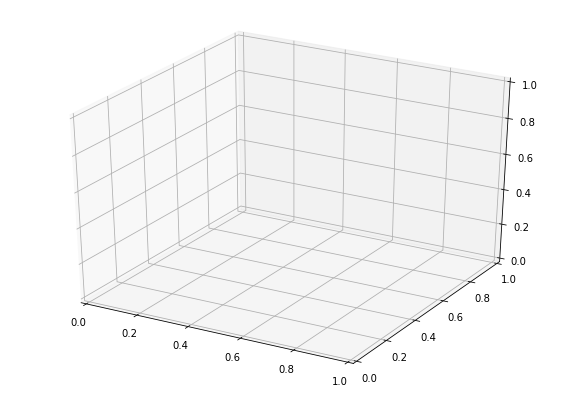

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = mean_target_part1
y = mean_target_part4
z = mean_target_part2
c = mean_target_part3

x1 = mean_standard_part1
y1 = mean_standard_part4
z1 = mean_standard_part2
c1 = mean_standard_part3

img2 = ax.scatter(x1, y1, z1, c=c1, s = 100, marker = "*", cmap=plt.winter())
cbar = fig.colorbar(img2)
cbar.set_label('Pendiente de la ventana 1')

ax.set_xlabel('Pendiente de la ventana 3')
ax.set_ylabel('Pendiente de la ventana 4')
ax.set_zlabel('Pendiente de la ventana 2')
ax.set_label('Pendiente de la ventana 1')
plt.title('Pendientes en diferentes ventanas, los + P300 y los * son No P300')


img = ax.scatter(x, y, z, c=c, s = 100,marker = "+", cmap=plt.winter())
ax.view_init(40, 10)
#fig.colorbar(img,img2)
fig.savefig('scatter_Competition')
plt.show()

In [13]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
print(featuresT.shape)
print(featuresF.shape)

(10026, 4)
(50128, 4)


In [14]:
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
print(labelT.shape)
print(labelF.shape)

(10026,)
(50128,)


In [15]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(60154, 4)
(60154,)


## División del dataset

In [16]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate


In [17]:

# Crear los datos de las características (X) y las etiquetas de las clases (y)
# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el subconjunto de train en train y validation usando una proporción de 75/25
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Mostrar el resultado
print(X_train.shape) # (2052, 4)
print(X_val.shape) # (684, 4)
print(X_test.shape) # (684, 4)

(36092, 4)
(12031, 4)
(12031, 4)


## Entrenamiento

In [18]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, make_scorer

# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crear el clasificador de discriminante lineal
lda = LinearDiscriminantAnalysis()

# Crear un diccionario que mapee los nombres de las métricas con las funciones
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores1 = cross_validate(lda, X, y, cv=20, scoring=scoring)


print('F1 SCORE:', scores1['test_f1'].mean())
print('Recall:', scores1['test_recall'].mean())
print('Precision:', scores1['test_precision'].mean())
print('Accuracy:', scores1['test_accuracy'].mean())
#print(scores1)

F1 SCORE: 0.09049011759133134
Recall: 0.04807916307161346
Precision: 0.8771278122626208
Accuracy: 0.8381914766201302


In [19]:
from sklearn import tree

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
tr = tree.DecisionTreeClassifier(max_depth=7)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores2 = cross_validate(tr, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores2['test_f1'].mean())
print('Recall:', scores2['test_recall'].mean())
print('Precision:', scores2['test_precision'].mean())
print('Accuracy:', scores2['test_accuracy'].mean())
#print(scores2)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores3 = cross_validate(rfc, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores3['test_f1'].mean())
print('Recall:', scores3['test_recall'].mean())
print('Precision:', scores3['test_precision'].mean())
print('Accuracy:', scores3['test_accuracy'].mean())
#print(scores3)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [21]:
from sklearn.svm import SVC

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
svm = SVC(gamma="auto",kernel='rbf', C=1)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores4 = cross_validate(svm, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores4['test_f1'].mean())
print('Recall:', scores4['test_recall'].mean())
print('Precision:', scores4['test_precision'].mean())
print('Accuracy:', scores4['test_accuracy'].mean())
#print(scores4)

F1 SCORE: 0.9941338467923359
Recall: 1.0
Precision: 0.9883476916505443
Accuracy: 0.9980050795093698


## Test

In [22]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
def evaluacion (y_test, y_predi):
  cm = confusion_matrix(y_test, y_predi, normalize='true')
  acc = accuracy_score(y_true=y_test , y_pred= y_predi)
  pre = precision_score(y_true=y_test , y_pred= y_predi)
  rec = recall_score(y_true=y_test , y_pred= y_predi)
  f1 = f1_score(y_true=y_test , y_pred= y_predi)
  k = cohen_kappa_score(y1=y_test, y2=y_predi)

  return {'Conf_Matrix':[cm],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1_Score':f1,'Cohen_Kappa':k}

def comparar_modelos(y_test,y_predi,modelos):
  for i in range(len(y_test)):
    eval = evaluacion(y_test[i],y_predi[i])
    if(i==0):
      df = pd.DataFrame(eval, index=[0])
    else:
      df = df.append(eval, ignore_index=True)
  df['modelo'] = modelos
  df = df.reindex(columns=['modelo', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Cohen_Kappa','Conf_Matrix'])
  fig = df.plot(kind = 'bar', x='modelo')
  #hist_modelos(df)
  return df, fig

4 4


,modelo,Accuracy,Precision,Recall,F1_Score,Cohen_Kappa,Conf_Matrix
0,LDA,0.839165,0.87156,0.047123,0.089412,0.073485,"[[0.9986020968547179, 0.001397903145282077], [..."
1,Tree,1.000000,1.00000,1.000000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
2,RF,1.000000,1.00000,1.000000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
3,SVM,0.839165,0.87156,0.047123,0.089412,0.073485,"[[[0.9986020968547179, 0.001397903145282077], ..."


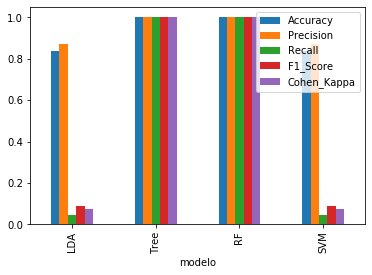

In [23]:
lda.fit(X, y)
tr = tr.fit(X_train, y_train)
rfc.fit(X, y)
svm.fit(X, y)

y_pred_lda = lda.predict(X_test)
y_pred_tr = tr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_svm = lda.predict(X_test)
Y_test = [y_test, y_test, y_test, y_test]
y_predi = [y_pred_lda, y_pred_tr, y_pred_rfc, y_pred_svm]
print(len(Y_test), len(y_predi))
modelos = ['LDA','Tree','RF','SVM']
df, fig = comparar_modelos(Y_test,y_predi,modelos)
df

In [24]:
#from sklearn.metrics import clasification_report
#print(clasification_report(y_test, y_pred_rfc))

https://www.fisterra.com/formacion/metodologia-investigacion/medidas-concordancia-indice-kappa/

In [25]:
#importances = rfc.feature_importances_
#print(importances)
#columns = ['M ventana 1', 'M ventana 2', 'M ventana 3', 'M ventana 4']
#print(columns)
#sns.barplot(x=columns, y=importances, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
#plt.title('Importancia de cada Feature')
#plt.show()

In [26]:
#import graphviz
#dot_data = tree.export_graphviz(tr, out_file=None)
#graph = graphviz.Source(dot_data)
#graph.render("iris")


#dot_data = tree.export_graphviz(tr, out_file=None,
#                         feature_names=columns,
#                         class_names='P300',
#                         filled=True, rounded=True,
#                         special_characters=True)
#graph = graphviz.Source(dot_data)
#graph

In [27]:
import pandas as pd
def tup2data(scores1, clasificador):
  data_tuples = list(zip(scores1.keys(), scores1.values()))
  df1 = pd.DataFrame(data=data_tuples, columns=['metric', 'values'])
  df1 = df1.explode('values')
  df1['classifier'] = clasificador
  return df1

In [28]:
df1 = tup2data(scores1,'LDA')
df2 = tup2data(scores2,'Tree')
df3 = tup2data(scores3,'RF')
df4 = tup2data(scores4,'SVM')

In [29]:
df = pd.concat([df1, df2, df3, df4], axis = 0)
df

,metric,values,classifier
0,fit_time,0.0182858,LDA
0,fit_time,0.019556,LDA
0,fit_time,0.0193665,LDA
0,fit_time,0.0216708,LDA
0,fit_time,0.0196431,LDA
...,...,...,...
5,test_accuracy,0.997228,SVM
5,test_accuracy,0.997228,SVM
5,test_accuracy,0.997783,SVM
5,test_accuracy,0.998337,SVM


In [30]:
metrics_to_select = ['test_f1', 'test_recall', 'test_precision', 'test_accuracy']
df_selected = df.loc[df['metric'].isin(metrics_to_select)]
df_selected

,metric,values,classifier
2,test_f1,0.0447284,LDA
2,test_f1,0.0626959,LDA
2,test_f1,0.0384615,LDA
2,test_f1,0.155224,LDA
2,test_f1,0.056962,LDA
...,...,...,...
5,test_accuracy,0.997228,SVM
5,test_accuracy,0.997228,SVM
5,test_accuracy,0.997783,SVM
5,test_accuracy,0.998337,SVM


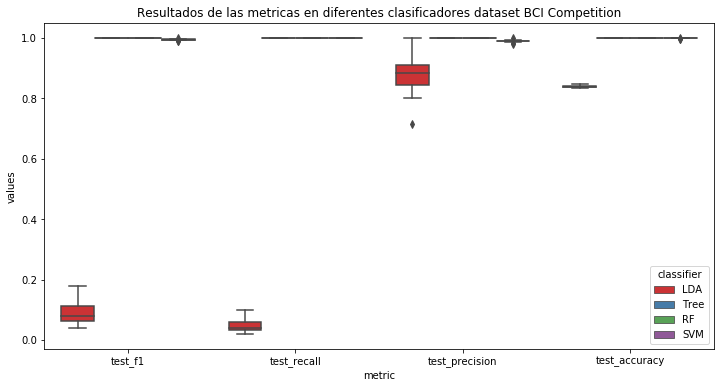

In [31]:
# DATOS DE ENTRADA
variable_numerica = "values"
variable_categorica_agrupacion = "metric"
variable_categorica_agrupacion2 = "classifier"
titulo_grafico = "Resultados de las metricas en diferentes clasificadores dataset BCI Competition"

#Gráfico Boxplot a una sola variable númerica según dos categorica
plt.figure(figsize=(12,6))
sns.boxplot(x=variable_categorica_agrupacion, y=variable_numerica, hue=variable_categorica_agrupacion2, data=df_selected, palette="Set1")
plt.title(titulo_grafico)
plt.savefig('boxplot_Competition')
plt.show()

# Electrodos promediados
Se utiliza Keras para realizar la clasificación

In [32]:
epochs = mne.read_epochs('Data/epocas/elect_mean_epo.fif')
epochs.info

Reading /home/ivandanielvillegas/work/home/BrainInvaders/Data/epocas/elect_mean_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -304.00 ...     688.00 ms
        0 CTF compensation matrices available
Not setting metadata
60154 matching events found
No baseline correction applied
0 projection items activated


<Info | 9 non-empty values
 bads: []
 ch_names: O, C, P, F
 chs: 4 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 4
 projs: []
 sfreq: 125.0 Hz
>

In [33]:
pick_channels = ['F','C','P','O']
target = epochs["1"].pick_channels(pick_channels)#.average()
target

Number of events,10026
Events,1: 10026
Time range,-0.304 – 0.688 sec
Baseline,off


In [34]:
standard = epochs["0"].pick_channels(pick_channels)#.average()
standard

Number of events,50128
Events,0: 50128
Time range,-0.304 – 0.688 sec
Baseline,off


In [35]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_DADT(target,-0.3,0,0.25,0.4,0.7)
print(mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape)

mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_DADT(standard,-0.3,0,0.25,0.4,0.7)
print(mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape)

<ipython-input-9-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.688 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(10026, 4) (10026, 4) (10026, 4) (10026, 4)


<ipython-input-9-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.688 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


(50128, 4) (50128, 4) (50128, 4) (50128, 4)


ValueError: 'c' argument has 50128 elements, which is not acceptable for use with 'x' with size 200512, 'y' with size 200512.

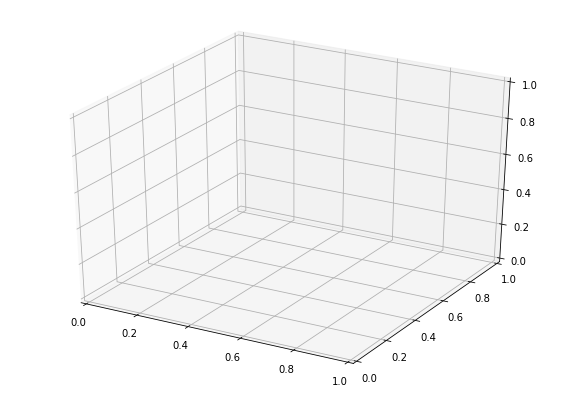

In [36]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = mean_target_part1
y = mean_target_part4
z = mean_target_part2
c = mean_target_part3

x1 = mean_standard_part1
y1 = mean_standard_part4
z1 = mean_standard_part2
c1 = mean_standard_part3

img2 = ax.scatter(x1, y1, z1, c=c1, s = 100, marker = "*", cmap=plt.winter())
cbar = fig.colorbar(img2)
cbar.set_label('Pendiente de la ventana 1')

ax.set_xlabel('Pendiente de la ventana 3')
ax.set_ylabel('Pendiente de la ventana 4')
ax.set_zlabel('Pendiente de la ventana 2')
ax.set_label('Pendiente de la ventana 1')
plt.title('Pendientes en diferentes ventanas, los + P300 y los * son No P300')


img = ax.scatter(x, y, z, c=c, s = 100,marker = "+", cmap=plt.winter())
ax.view_init(40, 10)
#fig.colorbar(img,img2)
fig.savefig('scatter_Competition')
plt.show()

In [37]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
print('Features True shape', featuresT.shape)
print('Features False shape',featuresF.shape)

labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
print(labelT.shape)
print(labelF.shape)

Features True shape (10026, 16)
Features False shape (50128, 16)
(10026,)
(50128,)


In [38]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(60154, 16)
(60154,)


## División del dataset

In [39]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate

In [40]:
# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el subconjunto de train en train y validation usando una proporción de 75/25
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Mostrar el resultado
print(X_train.shape) # (2052, 4)
print(X_val.shape) # (684, 4)
print(X_test.shape) # (684, 4)

(36092, 16)
(12031, 16)
(12031, 16)


## Entrenamiento

In [41]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, make_scorer

# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crear el clasificador de discriminante lineal
lda = LinearDiscriminantAnalysis()

# Crear un diccionario que mapee los nombres de las métricas con las funciones
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores1 = cross_validate(lda, X, y, cv=20, scoring=scoring)


print('F1 SCORE:', scores1['test_f1'].mean())
print('Recall:', scores1['test_recall'].mean())
print('Precision:', scores1['test_precision'].mean())
print('Accuracy:', scores1['test_accuracy'].mean())
#print(scores1)

F1 SCORE: 0.6048361174039218
Recall: 0.43609738999137193
Precision: 0.9907274805427511
Accuracy: 0.9040784713563579


In [42]:
from sklearn import tree

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
tr = tree.DecisionTreeClassifier(max_depth=7)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores2 = cross_validate(tr, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores2['test_f1'].mean())
print('Recall:', scores2['test_recall'].mean())
print('Precision:', scores2['test_precision'].mean())
print('Accuracy:', scores2['test_accuracy'].mean())
#print(scores2)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores3 = cross_validate(rfc, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores3['test_f1'].mean())
print('Recall:', scores3['test_recall'].mean())
print('Precision:', scores3['test_precision'].mean())
print('Accuracy:', scores3['test_accuracy'].mean())
#print(scores3)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [44]:
from sklearn.svm import SVC

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
svm = SVC(gamma="auto",kernel='rbf', C=1)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores4 = cross_validate(svm, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores4['test_f1'].mean())
print('Recall:', scores4['test_recall'].mean())
print('Precision:', scores4['test_precision'].mean())
print('Accuracy:', scores4['test_accuracy'].mean())
#print(scores4)

F1 SCORE: 0.9898696245816085
Recall: 0.9799822044866267
Precision: 1.0
Accuracy: 0.9966197308535666


## Test

4 4


,modelo,Accuracy,Precision,Recall,F1_Score,Cohen_Kappa,Conf_Matrix
0,LDA,0.906658,0.99556,0.44494,0.615015,0.570562,"[[0.999600599101348, 0.00039940089865202194], ..."
1,Tree,1.000000,1.00000,1.00000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
2,RF,1.000000,1.00000,1.00000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
3,SVM,0.906658,0.99556,0.44494,0.615015,0.570562,"[[[0.999600599101348, 0.00039940089865202194],..."


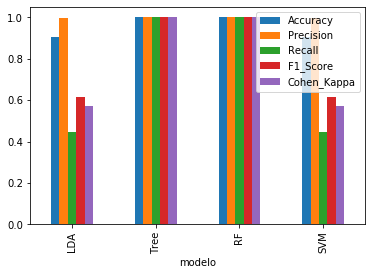

In [45]:
lda.fit(X, y)
tr = tr.fit(X_train, y_train)
rfc.fit(X, y)
svm.fit(X, y)

y_pred_lda = lda.predict(X_test)
y_pred_tr = tr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_svm = lda.predict(X_test)
Y_test = [y_test, y_test, y_test, y_test]
y_predi = [y_pred_lda, y_pred_tr, y_pred_rfc, y_pred_svm]
print(len(Y_test), len(y_predi))
modelos = ['LDA','Tree','RF','SVM']
df, fig = comparar_modelos(Y_test,y_predi,modelos)
df

In [46]:
import pandas as pd
def tup2data(scores1, clasificador):
  data_tuples = list(zip(scores1.keys(), scores1.values()))
  df1 = pd.DataFrame(data=data_tuples, columns=['metric', 'values'])
  df1 = df1.explode('values')
  df1['classifier'] = clasificador
  return df1

In [47]:
df1 = tup2data(scores1,'LDA')
df2 = tup2data(scores2,'Tree')
df3 = tup2data(scores3,'RF')
df4 = tup2data(scores4,'SVM')

df = pd.concat([df1, df2, df3, df4], axis = 0)
df

,metric,values,classifier
0,fit_time,0.0488133,LDA
0,fit_time,0.0580227,LDA
0,fit_time,0.0578444,LDA
0,fit_time,0.057683,LDA
0,fit_time,0.0577757,LDA
...,...,...,...
5,test_accuracy,0.996674,SVM
5,test_accuracy,0.993902,SVM
5,test_accuracy,0.994457,SVM
5,test_accuracy,0.998337,SVM


In [48]:
metrics_to_select = ['test_f1', 'test_recall', 'test_precision', 'test_accuracy']
df_selected = df.loc[df['metric'].isin(metrics_to_select)]
df_selected

,metric,values,classifier
2,test_f1,0.535885,LDA
2,test_f1,0.621924,LDA
2,test_f1,0.580046,LDA
2,test_f1,0.626667,LDA
2,test_f1,0.594966,LDA
...,...,...,...
5,test_accuracy,0.996674,SVM
5,test_accuracy,0.993902,SVM
5,test_accuracy,0.994457,SVM
5,test_accuracy,0.998337,SVM


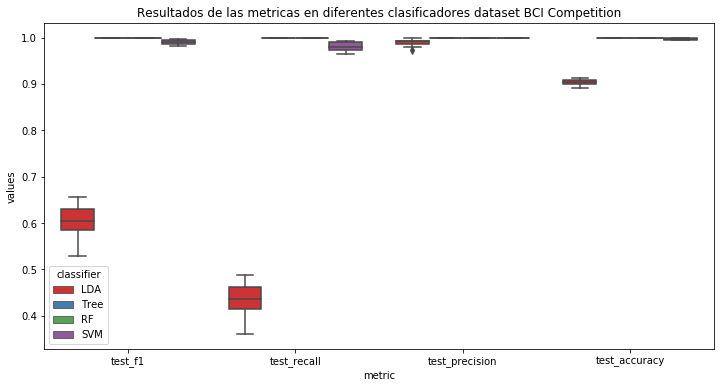

In [49]:
# DATOS DE ENTRADA
variable_numerica = "values"
variable_categorica_agrupacion = "metric"
variable_categorica_agrupacion2 = "classifier"
titulo_grafico = "Resultados de las metricas en diferentes clasificadores dataset BCI Competition"

#Gráfico Boxplot a una sola variable númerica según dos categorica
plt.figure(figsize=(12,6))
sns.boxplot(x=variable_categorica_agrupacion, y=variable_numerica, hue=variable_categorica_agrupacion2, data=df_selected, palette="Set1")
plt.title(titulo_grafico)
plt.savefig('boxplot_Competition')
plt.show()

# Data normalizada

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

lda = LinearDiscriminantAnalysis()
tr = tree.DecisionTreeClassifier(max_depth=7)
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
svm = SVC(gamma="auto",kernel='rbf', C=1)

clf_lda = make_pipeline(Normalizer(), lda)
clf_tr = make_pipeline(Normalizer(), tr)
clf_rfc = make_pipeline(Normalizer(), rfc)
clf_svm = make_pipeline(Normalizer(), svm)

In [51]:
clf_lda.fit(X, y)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)

In [52]:
clf_tr.fit(X, y)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=7,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [53]:
clf_rfc.fit(X, y)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=2, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [54]:
clf_svm.fit(X, y)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

4 4


,modelo,Accuracy,Precision,Recall,F1_Score,Cohen_Kappa,Conf_Matrix
0,LDA,1.0,1.0,1.0,1.0,1.0,"[[1.0, 0.0], [0.0, 1.0]]"
1,Tree,1.0,1.0,1.0,1.0,1.0,"[[[1.0, 0.0], [0.0, 1.0]]]"
2,RF,1.0,1.0,1.0,1.0,1.0,"[[[1.0, 0.0], [0.0, 1.0]]]"
3,SVM,1.0,1.0,1.0,1.0,1.0,"[[[1.0, 0.0], [0.0, 1.0]]]"


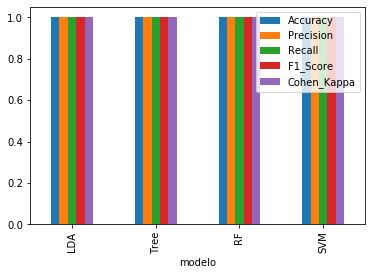

In [55]:
y_pred_lda = clf_lda.predict(X_test)
y_pred_tr = clf_tr.predict(X_test)
y_pred_rfc = clf_rfc.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
Y_test = [y_test, y_test, y_test, y_test]
y_predi = [y_pred_lda, y_pred_tr, y_pred_rfc, y_pred_svm]
print(len(Y_test), len(y_predi))
modelos = ['LDA','Tree','RF','SVM']
df, fig = comparar_modelos(Y_test,y_predi,modelos)
df